# Motivation
This step is required as the HDB price index taken from Data.gov.sg does not provide us with sufficient granularity to map price index for each month. Hence, this notebook is used to test for the accuracy of a model that predicts price movement of HDB Resale flats on a monthly basis.

# Data Cleaning
For this step, we map all of the values to Price per SQM using resale price and
floor_area_sqm. We will then utilize only month and floor_area_sqm to calculate the median rates per month.


In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import numpy as np

In [ ]:
df0 = pd.read_csv('Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv')
df1 = pd.read_csv('Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv')
df2 = pd.read_csv('Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv')
df3 = pd.read_csv('Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv')
df4 = pd.read_csv('Resale flat prices based on registration date from Jan-2017 onwards.csv')

df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)
df = df[(df['flat_type'] == '4 ROOM')]

In [ ]:
df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']

<ipython-input-5-670b7f5c061d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']


In [ ]:
## Get median price_per_sqft of each month
df_median = df.groupby(['month'])['price_per_sqm'].median().reset_index()
df_median_town = df.groupby(['month', 'town'])['price_per_sqm'].median().reset_index()

In [ ]:
df_median
df_median.to_csv("MedianPricePerMonth.csv")
df_median_town.to_csv("MedianPricePerMonthByTown.csv")

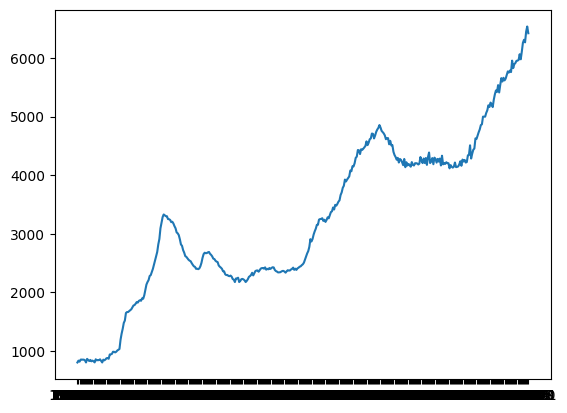

In [ ]:
## Plot the graph to visualize price movement
import matplotlib.pyplot as plt
plt.plot(df_median['month'], df_median['price_per_sqm'])
plt.show()

As you can see, the housing market follows a general upwards trend which takes into account near recent trends. Hence, we can attempt to model it with LSTM.

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
import numpy as np

In [ ]:
## Clean
df_median['month'] = pd.to_datetime(
    df_median['month'].str.replace(r'Q(\d)', lambda x: f"{int(x.group(1)) * 3 - 2:02}", regex=True),
    format='%Y-%m'
)

In [ ]:
df_median

,month,price_per_sqm
0,1990-01-01,806.122449
1,1990-02-01,838.095238
2,1990-03-01,819.868799
3,1990-04-01,854.368932
4,1990-05-01,855.769231
...,...,...
414,2024-07-01,6311.111111
415,2024-08-01,6267.326733
416,2024-09-01,6451.612903
417,2024-10-01,6538.461538


In [ ]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
train_data = df_median[(df_median['month'] >= '2008-01-01') &(df_median['month'] < '2022-01-01')]
train_data[["price_per_sqm"]] = Ms.fit_transform(train_data[["price_per_sqm"]])

df_median[["price_per_sqm"]] = Ms.transform(df_median[["price_per_sqm"]])
test_data  = df_median[(df_median['month'] >= '2022-03-01') & (df_median['month'] < '2024-03-01')]
pred_data = df_median[(df_median['month'] >= '2024-09-01') & (df_median['month'] < '2024-09-01')]
train_data["month"] = pd.to_datetime(train_data.month)
test_data["month"] = pd.to_datetime(test_data.month)
pred_data["month"] = pd.to_datetime(pred_data.month)
# train_data['month'] = df['month'].apply(lambda x: x.timestamp())
# test_data['month'] = df['month'].apply(lambda x: x.timestamp())

train_data.set_index('month', drop = True, inplace = True)
test_data.set_index('month', drop = True, inplace = True)
pred_data.set_index('month', drop = True, inplace = True)

<ipython-input-12-4d8d7ec47465>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[["price_per_sqm"]] = Ms.fit_transform(train_data[["price_per_sqm"]])
<ipython-input-12-4d8d7ec47465>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["month"] = pd.to_datetime(train_data.month)
<ipython-input-12-4d8d7ec47465>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [ ]:
train_data

,price_per_sqm
month,
2008-01-01,0.016783
2008-02-01,0.000000
2008-03-01,0.017978
2008-04-01,0.049917
2008-05-01,0.073219
...,...
2021-08-01,0.925894
2021-09-01,0.944758
2021-10-01,0.980571


In [ ]:
test_data

,price_per_sqm
month,
2022-03-01,1.020795
2022-04-01,1.059447
2022-05-01,1.087517
2022-06-01,1.077084
2022-07-01,1.125795
2022-08-01,1.073168
2022-09-01,1.128261
2022-10-01,1.176438
2022-11-01,1.151658


In [ ]:
pred_data

,price_per_sqm
month,
2023-09-01,1.248327
2023-10-01,1.276397
2023-11-01,1.284633
2023-12-01,1.300546
2024-01-01,1.302589
2024-02-01,1.306663
2024-03-01,1.348465
2024-04-01,1.311813
2024-05-01,1.368213


In [ ]:
def create_sequence(dataset):
    sequences = []
    labels = []

    # Start iterating to create sequences of 10 rows
    for start_idx in range(len(dataset) - 3):  # We subtract 10 so that the last sequence doesn't go out of bounds
        stop_idx = start_idx + 3  # We want sequences of 10 rows
        sequences.append(dataset.iloc[start_idx:stop_idx])  # Add the sequence
        labels.append(dataset.iloc[stop_idx])  # The label is the row immediately after the sequence

    return np.array(sequences), np.array(labels)

In [ ]:
print(len(train_data))
print(len(test_data))

168
24


In [ ]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)
pred_seq, pred_label = create_sequence(pred_data)
print(len(train_seq))
print(len(test_seq))
print(len(pred_seq))
print(pred_seq)

165
21
9
[[[1.24832733]
  [1.27639702]
  [1.28463332]]

 [[1.27639702]
  [1.28463332]
  [1.3005458 ]]

 [[1.28463332]
  [1.3005458 ]
  [1.302589  ]]

 [[1.3005458 ]
  [1.302589  ]
  [1.30666277]]

 [[1.302589  ]
  [1.30666277]
  [1.34846479]]

 [[1.30666277]
  [1.34846479]
  [1.31181349]]

 [[1.34846479]
  [1.31181349]
  [1.36821275]]

 [[1.31181349]
  [1.36821275]
  [1.43065257]]

 [[1.36821275]
  [1.43065257]
  [1.452246  ]]]


In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1))
model.add(LSTM(units=100))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,402 (474.23 KB)

 Trainable params: 121,402 (474.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_seq, train_label, epochs=150,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.3299 - mean_absolute_error: 0.5413 - val_loss: 0.9673 - val_mean_absolute_error: 0.9816
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1858 - mean_absolute_error: 0.3971 - val_loss: 0.4196 - val_mean_absolute_error: 0.6462
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0506 - mean_absolute_error: 0.1955 - val_loss: 0.0041 - val_mean_absolute_error: 0.0585
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0212 - mean_absolute_error: 0.1299 - val_loss: 0.0035 - val_mean_absolute_error: 0.0545
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0148 - mean_absolute_error: 0.1068 - val_loss: 0.0653 - val_mean_absolute_error: 0.2539
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mean_absolute_error: 0.0748 - val_loss: 0.1077 - val_mean_absolute_error: 0.3265
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - mean_absolute_error: 0.0841 - val_loss: 0.04

In [ ]:
test_predicted = model.predict(test_seq)
train_predicted = model.predict(train_seq)

test_predicted = Ms.inverse_transform(test_predicted)
test_label = Ms.inverse_transform(test_label)
train_predicted = Ms.inverse_transform(train_predicted)
train_label = Ms.inverse_transform(train_label)

print(test_seq)

np.savetxt("test_predicted.csv", test_predicted, delimiter=",")
np.savetxt("train_predicted.csv", train_predicted, delimiter=",")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
[[[1.02079487]
  [1.05944737]
  [1.08751693]]

 [[1.05944737]
  [1.08751693]
  [1.07708406]]

 [[1.08751693]
  [1.07708406]
  [1.1257946 ]]

 [[1.07708406]
  [1.1257946 ]
  [1.07316801]]

 [[1.1257946 ]
  [1.07316801]
  [1.12826104]]

 [[1.07316801]
  [1.12826104]
  [1.17643847]]

 [[1.12826104]
  [1.17643847]
  [1.15165769]]

 [[1.17643847]
  [1.15165769]
  [1.1787244 ]]

 [[1.15165769]
  [1.1787244 ]
  [1.16000795]]

 [[1.1787244 ]
  [1.16000795]
  [1.17265695]]

 [[1.16000795]
  [1.17265695]
  [1.19871313]]

 [[1.17265695]
  [1.19871313]
  [1.22450775]]

 [[1.19871313]
  [1.22450775]
  [1.21655958]]

 [[1.22450775]
  [1.21655958]
  [1.23100634]]

 [[1.21655958]
  [1.23100634]
  [1.2200126 ]]

 [[1.23100634]
  [1.2200126 ]
  [1.3021789 ]]

 [[1.2200126 ]
  [1.3021789 ]
  [1.24832733]]

 [[1.3021789 ]
  [1.24832733]
  [1.27639702]]

 [[1.24832733]
  [1.27639702]
  [1.28463332]]

 [[1.27639702]
  [1.28463332]

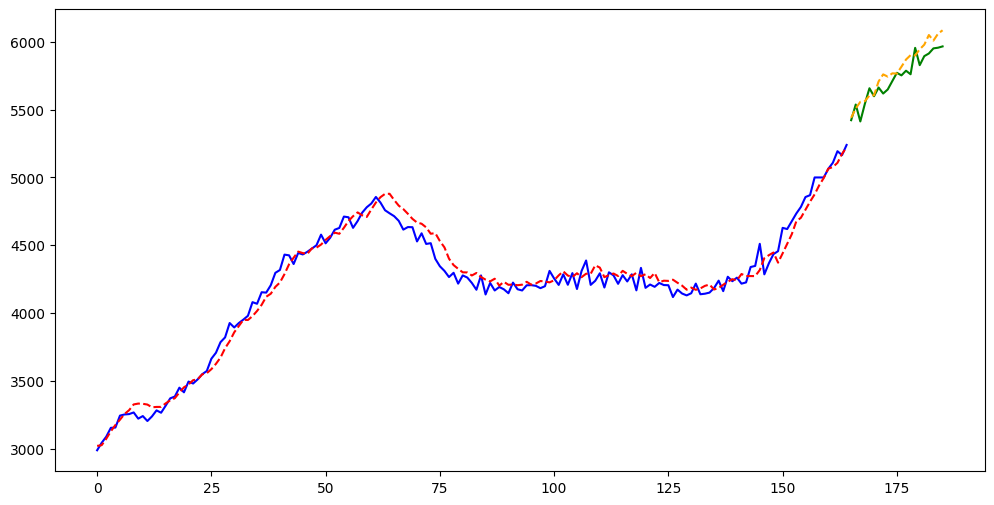

In [ ]:

import matplotlib.pyplot as plt


# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(np.arange(len(train_label)), train_label[:, 0], label='Actual Index (Training)', color='blue')
plt.plot(np.arange(len(train_predicted)), train_predicted[:, 0], label='Predicted Index (Training)', color='red', linestyle='--')

# Plot test data (append after the training data without a gap)
plt.plot(np.arange(len(train_label), len(train_label) + len(test_label)),
         test_label[:, 0], label='Actual Index (Test)', color='green')
plt.plot(np.arange(len(train_label), len(train_label) + len(test_predicted)),
         test_predicted[:, 0], label='Predicted Index (Test)', color='orange', linestyle='--')


In [ ]:
df_median

,month,price_per_sqm
0,1990-01-01,-0.871174
1,1990-02-01,-0.857680
2,1990-03-01,-0.865372
3,1990-04-01,-0.850811
4,1990-05-01,-0.850220
...,...,...
414,2024-07-01,1.452246
415,2024-08-01,1.433766
416,2024-09-01,1.511546
417,2024-10-01,1.548201


In [ ]:
# Predicting the next 4 periods (time steps)
predicted_future = []
input_sequence = pred_seq[-1]  # Start from the last sequence in the train set
input_sequence = np.roll(input_sequence, shift=-1, axis=0)
input_sequence[-1, 0] = df_median[(df_median["month"] == "2024-08")]["price_per_sqm"]  # Insert the prediction as the last value
print(input_sequence)

for _ in range(4):
    # Predict the next time step
    future_pred = model.predict(input_sequence[np.newaxis, :, :])  # Predicting the next step
    predicted_future.append(future_pred[0, 0])  # Append the predicted value

    # Update the input sequence for the next prediction (shift the sequence forward)
    input_sequence = np.roll(input_sequence, shift=-1, axis=0)
    input_sequence[-1, 0] = future_pred[0, 0]  # Insert the prediction as the last value
    print(input_sequence)

# Rescale the predicted future values back to the original scale
predicted_future_rescaled = Ms.inverse_transform(np.array(predicted_future).reshape(-1, 1))
print(predicted_future_rescaled)
# Unscale the actual train and test data before combining

# Create a new DataFrame with the next 30 predicted periods
index = [i for i in range(4)]

# Append the predicted values for the next 4 periods to the DataFrame
predicted_df = pd.DataFrame({
    'month': index,
    'price_per_sqft': predicted_future_rescaled.flatten()
})

# Combine the original unscaled data and the predicted data

predicted_df.to_csv("Output_LSTM_HDB_Index_1.csv")
# Display the DataFrame with both actual and predicted values
print(predicted_df)


[[1.43065257]
 [1.452246  ]
 [1.43376648]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[1.452246  ]
 [1.43376648]
 [1.5173372 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<ipython-input-24-b5dc080c86d8>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_sequence[-1, 0] = df_median[(df_median["month"] == "2024-08")]["price_per_sqm"]  # Insert the prediction as the last value


[[1.43376648]
 [1.5173372 ]
 [1.53786778]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[1.5173372 ]
 [1.53786778]
 [1.56262052]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[1.53786778]
 [1.56262052]
 [1.62021196]]
[[6465.3345]
 [6513.979 ]
 [6572.6265]
 [6709.0806]]
   month  price_per_sqft
0      0     6465.334473
1      1     6513.979004
2      2     6572.626465
3      3     6709.080566
